In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers

In [2]:
def parseTXT(filename, datasetname):
    
    folder_path = 'C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/STM/Letter_dataset/'
    log_file_path = folder_path + filename + ".txt"
    dataset_path = folder_path + datasetname + ".txt"

    format = re.compile('\d+\,[ABCDEFGHIJKLMNOPQRSTUVWXYZ]\,-?(\d+)\,-?(\d+)\,-?(\d+)')

    # Clean txt file and have only numbers
    with open(log_file_path,'r') as data_file:
        with open(dataset_path,'w') as out_file:
            for counter,line in enumerate(data_file):
                if re.search(format,line):
                    out_file.write(line)

    # Now use panda to handle the dataset
    columnNames = ['acquisition','letter','ax','ay','az']
    dataset = pd.read_csv(dataset_path,header = None, names=columnNames,na_values=',')

    # Find the number of tests
    last_index = max(np.unique(dataset.acquisition))

    second_axis = [];
    for acq_index in range(1,last_index):
        second_axis.append(dataset[dataset.acquisition == acq_index].shape[0])

    dtensor = np.empty((0,3*min(second_axis))) # per definire altezza
    labels = np.empty((0))
    contains = []

    for acq_index in range(2,last_index):
        temp = dataset[dataset.acquisition == acq_index]
        ax = temp.ax
        ay = temp.ay
        az = temp.az
        timesteps = az.shape[0]
        dtensor = np.vstack([dtensor,np.concatenate((ax, ay, az))])
        labels = np.append(labels,np.unique(temp.letter))
        labels_lett = np.append(labels,np.unique(temp.letter))
    contains = np.append(contains, np.unique(labels_lett))

    labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

    print(f'******* Dataset for letter {contains}\n')
    print(f'Raw shape        -> {dataset.shape}')
    print(f'Columns          -> {columnNames}' )
    print()
    print(f'Tot samples      -> {last_index}')
    print(f'1 Sample is long -> {timesteps}')
    print()
    
    return dtensor, labels_lett

In [3]:
def parseTrainValid(dtensor, labels):
    
    sep = int(0.15*dtensor.shape[0])
    
    sample_index = list(range(0,dtensor.shape[0]))
    shuffled_indexes = np.random.shuffle(sample_index)

    train_data = dtensor[sample_index[sep:],:]
    #train_labels = labels[sample_index[sep:],:]
    train_labels_lett = labels[sample_index[sep:]]

    test_data = dtensor[sample_index[:sep],:]
    #test_labels = labels[sample_index[:sep],:]
    test_labels_lett = labels[sample_index[:sep]]

    train_shape = train_data.shape[1]
    print('\n*** Separate train-valid\n')
    print(f"Train data shape  -> {train_data.shape}")
    print(f"Train label shape -> {train_labels_lett.shape}")
    print()
    print(f"Test data shape   -> {test_data.shape}")
    print(f"Test label shape  -> {test_labels_lett.shape}")
    
    return train_data, train_labels_lett, test_data, test_labels_lett

## Parse datasets

In [4]:
vowels_data, vowels_label = parseTXT('raw_vowels', 'dataset_vowels')
train_data, train_label, test_data, test_label = parseTrainValid(vowels_data, vowels_label)

******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (60000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 300
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (254, 600)
Train label shape -> (254,)

Test data shape   -> (44, 600)
Test label shape  -> (44,)


In [5]:
B_data, B_label = parseTXT('raw_b', 'dataset_b')
B_train_data, B_train_label, B_test_data, B_test_label = parseTrainValid(B_data, B_label)

******* Dataset for letter ['B']

Raw shape        -> (5400, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 27
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (22, 600)
Train label shape -> (22,)

Test data shape   -> (3, 600)
Test label shape  -> (3,)


In [6]:
M_data, M_label = parseTXT('raw_m', 'dataset_m')
M_train_data, M_train_label, M_test_data, M_test_label = parseTrainValid(M_data, M_label)

******* Dataset for letter ['M']

Raw shape        -> (5000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 25
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (20, 600)
Train label shape -> (20,)

Test data shape   -> (3, 600)
Test label shape  -> (3,)


In [7]:
R_data, R_label = parseTXT('raw_r', 'dataset_r')
R_train_data, R_train_label, R_test_data, R_test_label = parseTrainValid(R_data, R_label)

******* Dataset for letter ['R']

Raw shape        -> (5000, 5)
Columns          -> ['acquisition', 'letter', 'ax', 'ay', 'az']

Tot samples      -> 25
1 Sample is long -> 200


*** Separate train-valid

Train data shape  -> (20, 600)
Train label shape -> (20,)

Test data shape   -> (3, 600)
Test label shape  -> (3,)


###  Dataset of all letters

In [8]:
# Create a matrix that contains all the train data

order_data_all = train_data
order_data_all = np.vstack(( order_data_all, B_train_data))
order_data_all = np.vstack(( order_data_all, R_train_data))
order_data_all = np.vstack(( order_data_all, M_train_data))

order_label_all = train_label
order_label_all = np.hstack(( order_label_all, B_train_label))
order_label_all = np.hstack(( order_label_all, R_train_label))
order_label_all = np.hstack(( order_label_all, M_train_label))

print('\nNew dataset of mixed data has shape ' + str(order_data_all.shape))
print('New dataset of mixed label has shape' + str(order_label_all.shape))


New dataset of mixed data has shape (316, 600)
New dataset of mixed label has shape(316,)


In [9]:
# Shuffle the matrix of all letters
mixed_data_all = np.zeros(order_data_all.shape)
mixed_label_all = np.empty(order_label_all.shape, dtype=str) 

index_ary = list(range(0, order_data_all.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_all.shape[0]):
    mixed_data_all[i,:] = order_data_all[index_ary[i],:]
    mixed_label_all[i]  = order_label_all[index_ary[i]]

###  Dataset of only new letters

In [10]:
# Create a matrix that contains all the train data

order_data_new = B_train_data
order_data_new = np.vstack(( order_data_new, R_train_data))
order_data_new = np.vstack(( order_data_new, M_train_data))

order_label_new = B_train_label
order_label_new = np.hstack(( order_label_new, R_train_label))
order_label_new = np.hstack(( order_label_new, M_train_label))

print('\nNew dataset of mixed data has shape ' + str(order_data_new.shape))
print('New dataset of mixed label has shape' + str(order_label_new.shape))


New dataset of mixed data has shape (62, 600)
New dataset of mixed label has shape(62,)


In [11]:
# Shuffle the matrix of all letters
mixed_data_new = np.zeros(order_data_new.shape)
mixed_label_new = np.empty(order_label_new.shape, dtype=str) 

index_ary = list(range(0, order_data_new.shape[0]))
index_ary = random.sample(index_ary, len(index_ary)) 

for i in range(0, order_data_new.shape[0]):
    mixed_data_new[i,:] = order_data_new[index_ary[i],:]
    mixed_label_new[i]  = order_label_new[index_ary[i]]

## Define ML model

In [12]:
def lettToSoft(ary, labels):
    ret_ary = np.zeros([len(ary), len(labels)])
    
    for i in range(0, len(ary)):
        for j in range(0, len(labels)):
            if(ary[i]==labels[j]):
                ret_ary[i,j] = 1

            
    return ret_ary   

In [13]:
# Basic parameters
optimizer = 'Adam'
loss    = 'categorical_crossentropy'
metrics = ['accuracy']
vowels = ['A', 'E', 'I', 'O', 'U']

epochs = 25
batch_size = 32

In [14]:
# Model structure
model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape =(train_data.shape[1],),name='input_layer'))
model.add(Dense(128, activation = 'relu', name='hidden1'))
#model.add(Dense(128, activation = 'relu', name='hidden2'))
model.add(Dense(5, activation='softmax' , name = 'output_layer'))

In [15]:
model.compile(optimizer= optimizer, loss=loss, metrics=metrics) #use sparse is each letter is an integer (es a->1 b->2 c->3 ..)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 5)                 645       
Total params: 94,085
Trainable params: 94,085
Non-trainable params: 0
_________________________________________________________________


### Train

In [16]:
# Perform training
train_hist = model.fit(train_data, lettToSoft(train_label, vowels), epochs=epochs, batch_size=batch_size, validation_split=0.2 , verbose=2)
print('\nEvaluation:')
results = model.evaluate(test_data, lettToSoft(test_label, vowels), verbose=2)

Epoch 1/25
7/7 - 0s - loss: 268.3032 - accuracy: 0.3596 - val_loss: 149.3108 - val_accuracy: 0.3529
Epoch 2/25
7/7 - 0s - loss: 54.5223 - accuracy: 0.6700 - val_loss: 76.1686 - val_accuracy: 0.6471
Epoch 3/25
7/7 - 0s - loss: 28.0103 - accuracy: 0.8374 - val_loss: 35.4488 - val_accuracy: 0.7451
Epoch 4/25
7/7 - 0s - loss: 11.0537 - accuracy: 0.8818 - val_loss: 26.8549 - val_accuracy: 0.8039
Epoch 5/25
7/7 - 0s - loss: 8.7449 - accuracy: 0.9310 - val_loss: 13.8988 - val_accuracy: 0.9608
Epoch 6/25
7/7 - 0s - loss: 5.7828 - accuracy: 0.9507 - val_loss: 15.0317 - val_accuracy: 0.9412
Epoch 7/25
7/7 - 0s - loss: 0.5005 - accuracy: 0.9852 - val_loss: 25.5480 - val_accuracy: 0.8627
Epoch 8/25
7/7 - 0s - loss: 4.3114 - accuracy: 0.9704 - val_loss: 23.4453 - val_accuracy: 0.9412
Epoch 9/25
7/7 - 0s - loss: 0.8207 - accuracy: 0.9852 - val_loss: 20.1646 - val_accuracy: 0.9020
Epoch 10/25
7/7 - 0s - loss: 1.0599 - accuracy: 0.9754 - val_loss: 13.9781 - val_accuracy: 0.9216
Epoch 11/25
7/7 - 0s - 

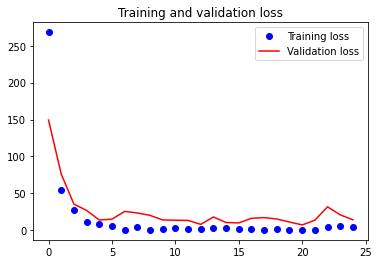

In [17]:
hist_loss = train_hist.history['loss']
hist_val_loss = train_hist.history['val_loss']
epoch_list = list(range(epochs))
plt.figure(1)
plt.plot(epoch_list, hist_loss, 'bo', label='Training loss')
plt.plot(epoch_list, hist_val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test

In [18]:
rand_n = int(random.uniform(0, test_data.shape[0]))
sample_data = test_data[rand_n,:].reshape(1,test_data.shape[1])
sample_label = test_label[rand_n]

pred = model.predict(sample_data)
print(f'True       -> {sample_label}')
print(f'Prediction -> {vowels[np.argmax(pred)]}' )

True       -> O
Prediction -> O


## Plot functions

In [19]:
def plotTest(data, label, model, letters):
    
    correct = 0
    mistaken = 0
    
    label = lettToSoft(label, letters)

    total = data.shape[0]

    for i in range(0, data.shape[0]):
        pred = model.predict(data[i,:].reshape(1,data.shape[1]))

        if (np.argmax(pred) == np.argmax(label[i])):
            correct +=1
        else:
            mistaken +=1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title('Test performance')

    langs = ['Correct', 'Error']
    langs.reverse
    bars = [correct,mistaken]
    bars.reverse
    ax.bar(langs,bars)
    plt.show()

    print(f"Total correct guesses {correct}  -> {round(correct/total,2)*100}%")
    print(f"Total mistaken guesses {mistaken} -> {round(mistaken/total,2)*100}%")

In [20]:
def testOL(model):

    corr_ary = np.zeros([8])
    err_ary = np.zeros([8])
    tot_ary = np.zeros([8])

    for j in range(0,4):

        if(j==0):
            data = test_data
            label = test_label
        elif(j==1):
            data = B_train_data
            label = B_train_label
        elif(j==2):
            data = R_train_data
            label = R_train_label
        elif(j==3):
            data = M_train_data
            label = M_train_label

        correct = 0
        mistaken = 0
        label_soft = lettToSoft(label,model.label)

        total = data.shape[0]

        for i in range(0, data.shape[0]):          
            ML_out = model.ML_frozen.predict(data[i,:].reshape(1,data.shape[1]))
            y_pred = model.predict(ML_out)

            
            # Find the max for borh the true label and the inference
            k = np.argmax(label_soft[i,:])

            max_true = 0
            max_i_true = 0
            
            max_pred = 0
            max_i_pred = 0
            for r in range(0, y_pred.shape[1]):
                if(max_true < label_soft[i,r]):
                    max_true = label_soft[i,r]
                    max_i_true = r
                if(max_pred < y_pred[0,r]):
                    max_pred = y_pred[0,r]
                    max_i_pred = r
            if (max_i_pred == max_i_true):
                correct +=1
                if(j==0):
                    corr_ary[k] += 1
                    tot_ary[k] += 1  
            else:
                mistaken +=1
                if(j==0):
                    err_ary[k] += 1  
                    tot_ary[k] += 1  
                
        if(j!=0):
            corr_ary[4+j] = correct
            err_ary[4+j] = mistaken
            tot_ary[4+j] = total
        
    return corr_ary, err_ary, tot_ary

In [21]:
def testOL_v2(model):

    corr_ary = np.zeros([8])
    err_ary = np.zeros([8])
    tot_ary = np.zeros([8])

    for j in range(0,4):

        if(j==0):
            data = test_data
            label = test_label
        elif(j==1):
            data = B_train_data
            label = B_train_label
        elif(j==2):
            data = R_train_data
            label = R_train_label
        elif(j==3):
            data = M_train_data
            label = M_train_label

        correct = 0
        mistaken = 0
        label_soft = lettToSoft(label,['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'])

        total = data.shape[0]

        for i in range(0, data.shape[0]):          
            y_pred = model.predict(data[i,:].reshape(1,data.shape[1]))
            
            k = np.argmax(label_soft[i,:])
            
            if (np.argmax(y_pred) == np.argmax(label_soft[i,:])):
                correct +=1
                if(j==0):
                    corr_ary[k] += 1
                    tot_ary[k] += 1
            else:
                mistaken +=1
                if(j==0):
                    err_ary[k] += 1
                    tot_ary[k] += 1

        if(j!=0):
            corr_ary[4+j] = correct
            err_ary[4+j] = mistaken
            tot_ary[4+j] = total
        
    return corr_ary, err_ary, tot_ary

In [22]:
def plotTestOL(corr_ary, err_ary, tot_ary, title):
    
    for i in range(0, len(corr_ary)):
        corr_ary[i] = int(round(corr_ary[i]/tot_ary[i], 2)*100)
        err_ary[i] = int(round(err_ary[i]/tot_ary[i], 2)*100)
    
    width = 0.25
    fig = plt.subplots(figsize =(12, 8))
    
    # Set position of bar on X axis
    br1 = np.arange(len(corr_ary))
    br2 = [x + width for x in br1]
    
    # Make the plot
    plt.bar(br1, corr_ary, color ='g', width = width, edgecolor ='grey', label ='Correct prediction')
    plt.bar(br2, err_ary, color ='r', width = width, edgecolor ='grey', label ='Wrong prediction')

    # Adding Xticks
    plt.ylabel('%', fontweight ='bold', fontsize = 15)
    plt.xticks([r + width for r in range(len(corr_ary))], ['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'],fontweight ='bold', fontsize = 15)
    plt.title(title)


    plt.legend()
    plt.show()

In [23]:
def tableTestOL(corr_ary, err_ary, tot_ary, title):

    val = np.zeros([2,len(corr_ary)])
    val[0,:] = np.round(np.round(corr_ary/tot_ary,2)*100,2)
    val[1,:] = np.round(np.round(err_ary/tot_ary,2)*100,2)

    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    
    table = ax.table( 
        cellText = val,  
        rowLabels = ['Correct', 'Error'],  
        colLabels = ['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M'], 
        rowColours =["palegreen"] * 200,  
        colColours =["palegreen"] * 200, 
        cellLoc ='center',  
        loc ='upper left')         

    ax.set_title(title, fontweight ="bold") 

    plt.show() 

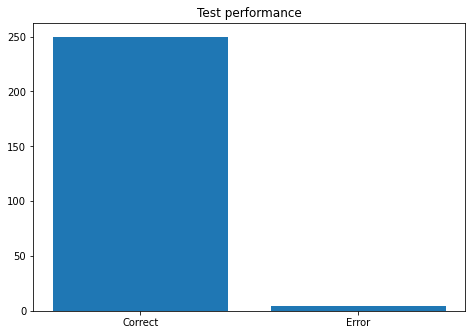

Total correct guesses 250  -> 98.0%
Total mistaken guesses 4 -> 2.0%


In [24]:
plotTest(train_data, train_label, model, vowels)

### Save model

In [25]:
def saveParams(SAVE_MODEL_PATH, model):
    
    new_file = open(SAVE_MODEL_PATH + '/params.txt', "w")

    new_file.write("PARAMETERS SAVED FROM THE TRAINING")
    new_file.write("\n Batch size: " + str(batch_size))
    new_file.write("\n Epochs: " + str(epochs))
    new_file.write("\n Validation split: " + str(0.2))
    new_file.write("\n Metrics: " + str(metrics))
    new_file.write("\n Optimizer: " + optimizer)
    new_file.write("\n Loss: " + loss + "\n\n")

    model.summary(print_fn=lambda x: new_file.write(x + '\n'))

In [26]:
SAVE_MODEL_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/model/"
model.save(SAVE_MODEL_PATH + "model.h5")
saveParams(SAVE_MODEL_PATH, model)

#  ------------------------------------------------------------------------

# TinyOL

### Functions

In [27]:
class Custom_Layer(object):
    def __init__(self, model):

        self.ML_frozen = keras.models.Sequential(model.layers[:-1])
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])
        self.b = np.array(model.layers[-1].get_weights()[1])
        self.label = ['A', 'E', 'I', 'O', 'U']
        
        self.width = self.W.shape[0]

    def predict(self, x):
        mat_prod = np.matmul(x, self.W) + self.b
        return tf.nn.softmax(mat_prod)      

In [28]:
def gradientDescent(y_true, y_pred, x, model, l_rate):
  
    cost = y_pred-y_true

    for j in range(0,128):
        # Update weights
        deltaW = np.multiply(cost, x[0,j])
        dW = np.multiply(deltaW, l_rate)
        model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, l_rate)
        model.b = model.b-db

In [29]:
def trainOneEpochOL(model, x, y_true, learn_rate):
    
    print('**********************************')
    print('Performing training with OL METHOD')
    print()
    
    
    
    cntr=1
    tot_samples = x.shape[0]
    # Transform the true label letters in softmax
    y_true_soft = lettToSoft(y_true, model.label)
        
        
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        # Check if letter is new
        found = 0
        for k in range(0, len(model.label)):
            if (y_true[i] == model.label[k]):
                found = 1

        # If first time seeing this letter
        if (found == 0):

            model.label.append(y_true[i])   # Add new letter to label

            print(f'\n\n    New letter detected -> letter \033[1m{y_true[i]}\033[0m \n')

            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))

            print(f'    Now W is -> {model.W.shape}              and b is -> {model.b.shape}')
            print()
            print()
            
            y_true_soft = lettToSoft(y_true, model.label)
        

        # Prediction from ML frozen model
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        # Prediction from TinyOL layer
        y_pred = model.predict(y_ML[0,:])
        
        for r in range(0, len(model.label)):
            if(y_pred[r] != y_true_soft[i,r]):
        
                # Apply backpropagation
                gradientDescent(y_true_soft[i,:], y_pred, y_ML, model, learn_rate)
                break
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],2)*100,2)}% of dataset                         ", end="")
        cntr +=1
        

In [30]:
def ML_predict(ML_model, data, OL_model):

    # Has shape [n samples, 128]
    data_mat = np.zeros([data.shape[0], OL_model.W.shape[0]])
    
    cntr = 1

    # Cycle over all samples
    for j in range(0, data.shape[0]):
        data_mat[j,:] = ML_model.predict(data[j,:].reshape(1,600))
        
        print(f'\rInferencing data ...     Now at:{cntr}/{data.shape[0]} ', end="")
        cntr += 1

    return data_mat

### Create ML model (cut model)

In [31]:
ML_model = keras.models.Sequential(model.layers[:-1])
ML_model.summary()
ML_model.compile()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 128)               76928     
_________________________________________________________________
hidden1 (Dense)              (None, 128)               16512     
Total params: 93,440
Trainable params: 93,440
Non-trainable params: 0
_________________________________________________________________


In [32]:
SAVE_MODEL_CUT_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/ML_model/"
ML_model.save(SAVE_MODEL_CUT_PATH + "model.h5")
saveParams(SAVE_MODEL_CUT_PATH, ML_model)

### TinyOL train parameters

In [33]:
num_epochs = 1
learn_rate = 0.001

# Trainings

### Train only vowels

In [34]:
Model_OL_vowels = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL(Model_OL_vowels, train_data, train_label, learn_rate)

**********************************
Performing training with OL METHOD

    Currently at 100.0% of dataset                         

### Train on all letters ordered

In [35]:
Model_OL_all_order = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL(Model_OL_all_order, order_data_all, order_label_all, learn_rate)

**********************************
Performing training with OL METHOD

    Currently at 80.0% of dataset                         

    New letter detected -> letter B 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 87.0% of dataset                         

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 94.0% of dataset                         

    New letter detected -> letter M 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset                         

### Train on all letters mixed

In [36]:
Model_OL_all_mixed = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL(Model_OL_all_mixed, mixed_data_all, mixed_label_all, learn_rate)

**********************************
Performing training with OL METHOD

    Currently at 1.0% of dataset                         

    New letter detected -> letter R 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 12.0% of dataset                         

    New letter detected -> letter B 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 16.0% of dataset                         

    New letter detected -> letter M 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset                         

### Train on new letters ordered

In [37]:
Model_OL_new_order = Custom_Layer(model)
for i in range(0, num_epochs):
    trainOneEpochOL(Model_OL_new_order, order_data_new, order_label_new, learn_rate)

**********************************
Performing training with OL METHOD



    New letter detected -> letter B 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 35.0% of dataset                         

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 68.0% of dataset                         

    New letter detected -> letter M 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset                         

### Train on new letters mixed

In [38]:
Model_OL_new_mixed = Custom_Layer(model)
for i in range(0, 1):
    trainOneEpochOL(Model_OL_new_mixed, mixed_data_new, mixed_label_new, 1)

**********************************
Performing training with OL METHOD



    New letter detected -> letter B 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.0% of dataset                         

    New letter detected -> letter M 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 3.0% of dataset                         

    New letter detected -> letter R 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset                         

# PLOTS

### Original model

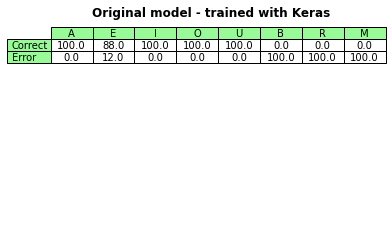

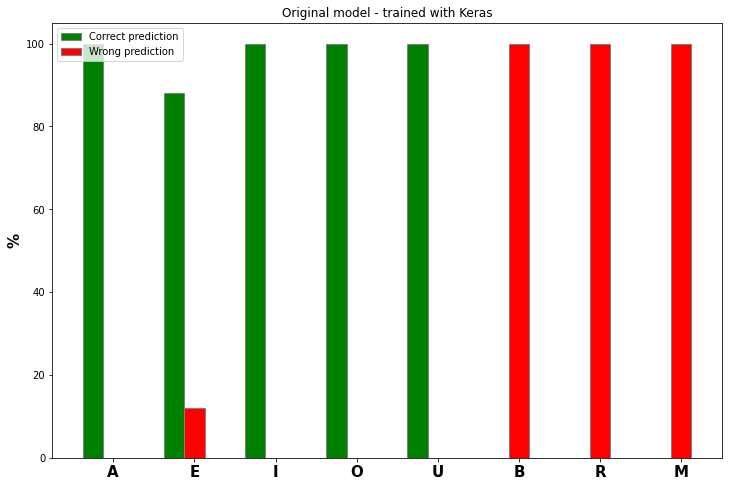

In [39]:
tmp1, tmp2, tmp3 = testOL_v2(model)
tableTestOL(tmp1, tmp2, tmp3, 'Original model - trained with Keras')
plotTestOL(tmp1, tmp2, tmp3, 'Original model - trained with Keras')

### Only vowels

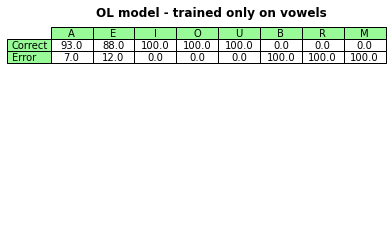

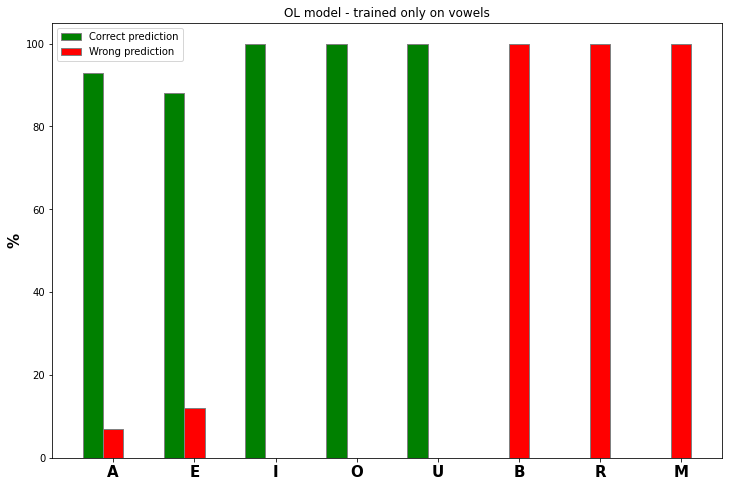

In [40]:
tmp1, tmp2, tmp3 = testOL(Model_OL_vowels)
tableTestOL(tmp1, tmp2, tmp3, 'OL model - trained only on vowels')
plotTestOL(tmp1, tmp2, tmp3, 'OL model - trained only on vowels')

### All and ordered

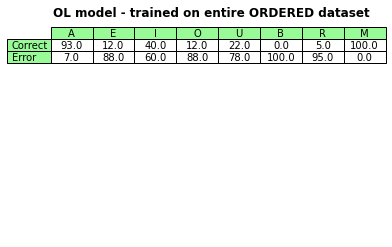

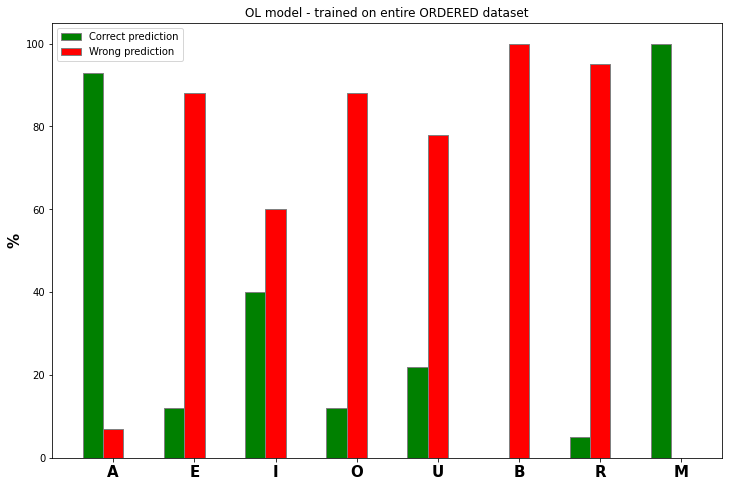

In [41]:
tmp1, tmp2, tmp3 = testOL(Model_OL_all_order)
tableTestOL(tmp1, tmp2, tmp3, 'OL model - trained on entire ORDERED dataset')
plotTestOL(tmp1, tmp2, tmp3, 'OL model - trained on entire ORDERED dataset')

### All and mixed

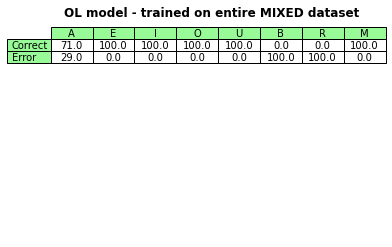

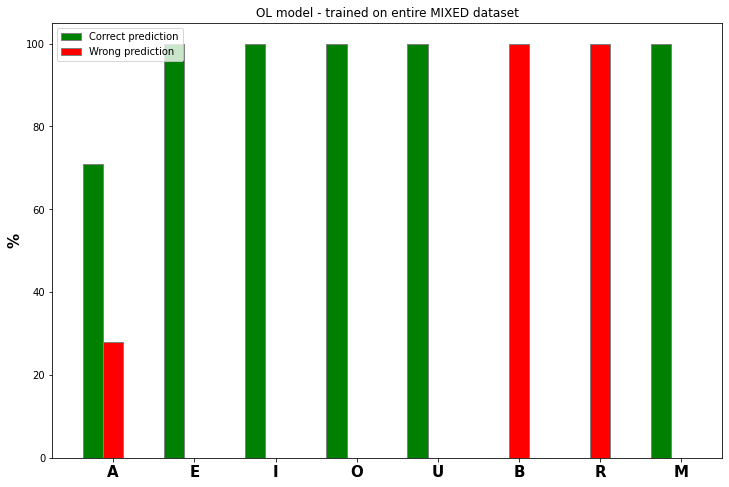

In [42]:
tmp1, tmp2, tmp3 = testOL(Model_OL_all_mixed)
tableTestOL(tmp1, tmp2, tmp3, 'OL model - trained on entire MIXED dataset')
plotTestOL(tmp1, tmp2, tmp3, 'OL model - trained on entire MIXED dataset')

### New and ordered

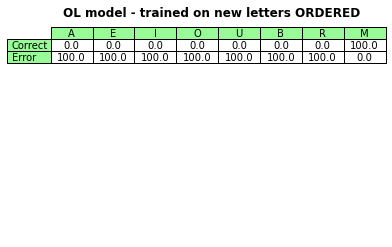

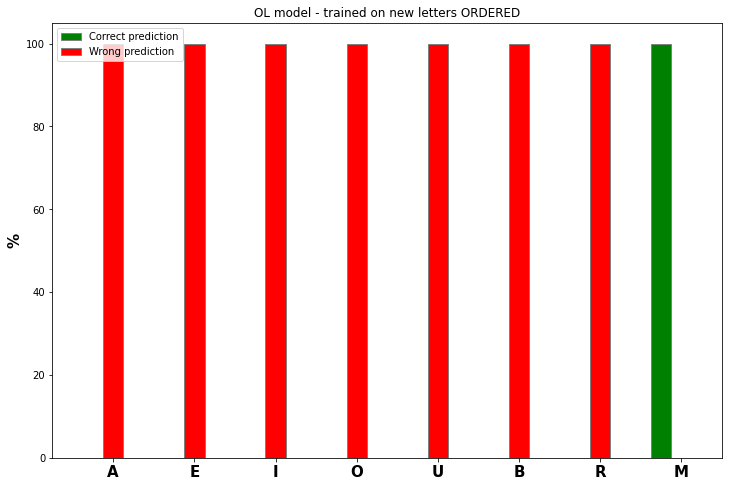

In [43]:
tmp1, tmp2, tmp3 = testOL(Model_OL_new_order)
tableTestOL(tmp1, tmp2, tmp3, 'OL model - trained on new letters ORDERED')
plotTestOL(tmp1, tmp2, tmp3, 'OL model - trained on new letters ORDERED')

### New and mixed

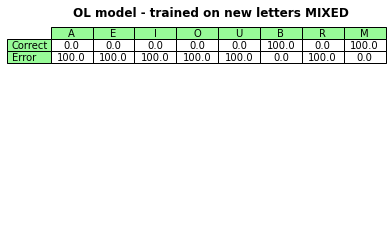

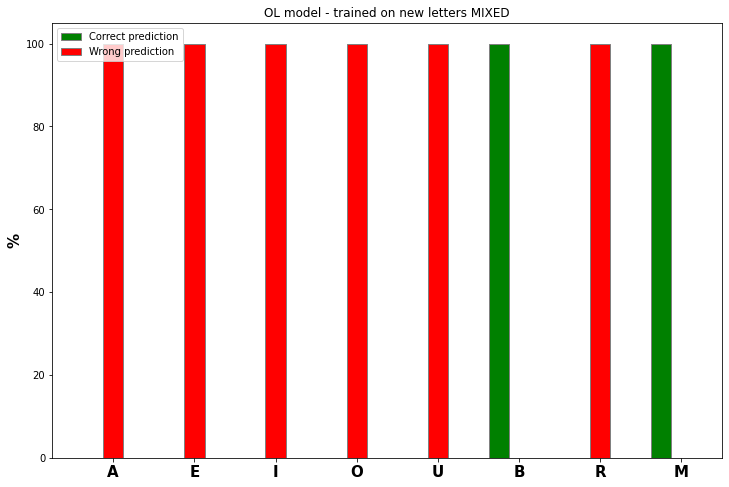

In [44]:
tmp1, tmp2, tmp3 = testOL(Model_OL_new_mixed)
tableTestOL(tmp1, tmp2, tmp3, 'OL model - trained on new letters MIXED')
plotTestOL(tmp1, tmp2, tmp3, 'OL model - trained on new letters MIXED')

# Scripts for generating libraries for the STM code

In [45]:
# WRITE THE VOWELS ON A TXT FILE

SAMPLE_LETTER_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_LETTER_PATH + '/sample_input.h', "w")

sample_A = test_data[1,:]

sample_E = test_data[9,:]
sample_I = test_data[4,:]
sample_O = test_data[0,:]
sample_U = test_data[3,:]

new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int sample_A[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_A[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_E[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_E[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_I[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_I[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_O[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_O[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')

new_file.write('\n\n\n')

new_file.write('int sample_U[600] = {')
for j in range(0, 600):
        new_file.write(str(int(sample_U[j])))
        
        if(j!=599):
            new_file.write(',')
        if((j%20==0) and (j!=0)):
            new_file.write('\n                     ')
new_file.write('};')


2

In [46]:
# WRITE THE LETTER B

SAMPLE_B_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_B_PATH + '/letter_B.h', "w")



new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int sample_B['+str(B_train_data.shape[0])+'][600] = {')
for i in range(0, B_train_data.shape[0]):
    new_file.write('\n          {')
    for j in range(0, 600):
            new_file.write(str(int(B_train_data[i,j])))
            if(j!=599):
                new_file.write(',')
            

    new_file.write('},')



In [47]:
# WRITE A MIX OF LETTERS IN A TXT FILE

SAMPLE_LETTERS_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Other/"

new_file = open(SAMPLE_LETTERS_PATH + '/letters.h', "w")

mix_of_letters = B_train_data[:12,:]
mix_of_letters = np.vstack(( mix_of_letters, test_data[:12,:]))

mix_of_labels = B_train_label[:12]
mix_of_labels = np.hstack(( mix_of_labels, test_label[:12]))

new_file.write("#include \"main.h\" \n\n\n")


new_file.write('int rand_letters['+str(mix_of_letters.shape[0])+'][600] = {')
for i in range(0, mix_of_letters.shape[0]):
    new_file.write('\n          {')
    for j in range(0, 600):
            new_file.write(str(int(mix_of_letters[i,j])))
            if(j!=599):
                new_file.write(',')
            
    if(i!=mix_of_letters.shape[0]-1):
        new_file.write('},')
    else:
        new_file.write('} };')
        
        
        
new_file.write('\n\n\n')
new_file.write('char rand_labels['+str(mix_of_labels.shape[0])+'] = {')
for i in range(0, mix_of_labels.shape[0]):
    
    new_file.write('\''+str(mix_of_labels[i])+'\'')
            
    if(i!=mix_of_labels.shape[0]-1):
        new_file.write(',')
    else:
        new_file.write('};')


In [48]:
# SAVE LAST LAYER OF MODEL IN .H FILE

LAST_LAYER_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/ML_model/"

new_file = open(LAST_LAYER_PATH + '/layer_weights.h', "w")

weights = np.array(model.layers[-1].get_weights()[0])
biases  = np.array(model.layers[-1].get_weights()[1])



new_file.write('float saved_weights['+str(weights.shape[0]*weights.shape[1])+'] = {')

for j in range(0, weights.shape[1]):
    new_file.write('\n                       ')
    
    for i in range(0, weights.shape[0]):     
        new_file.write(str(weights[i,j])+',')
        if(i%32==0 and i!=0):
            new_file.write('\n                       ')
            
new_file.write('}; \n\n\n\n')



new_file.write('float saved_biases['+str(biases.shape[0])+'] = {')
    
for i in range(0, biases.shape[0]):     
    new_file.write(str(biases[i]))   
    if(i != biases.shape[0]-1):
        new_file.write(',')
new_file.write('};')


2